# 레드 와인 Quailty 예측 모델

### 데이터 불러오기

In [29]:
import pandas as pd

data = pd.read_csv('data/winequality-red.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Pearson correlation 로 데이터 확인

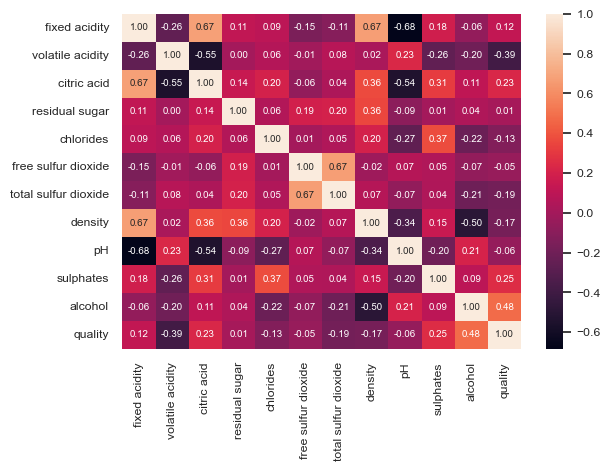

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr(method='pearson')
sns.set(font_scale=0.8)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            fmt='.2f',
            annot_kws={'size': 7},
            xticklabels=data.columns, 
            yticklabels=data.columns,
        )

plt.tight_layout()
plt.show()

### 상관계수가 마이너스인 변수들은 제거

In [31]:
nagetive_corr = corr[corr['quality'] < 0].index
data = data.drop(columns=nagetive_corr)
data

,fixed acidity,citric acid,residual sugar,sulphates,alcohol,quality
0,7.4,0.00,1.9,0.56,9.4,5
1,7.8,0.00,2.6,0.68,9.8,5
2,7.8,0.04,2.3,0.65,9.8,5
3,11.2,0.56,1.9,0.58,9.8,6
4,7.4,0.00,1.9,0.56,9.4,5
...,...,...,...,...,...,...
1594,6.2,0.08,2.0,0.58,10.5,5
1595,5.9,0.10,2.2,0.76,11.2,6
1596,6.3,0.13,2.3,0.75,11.0,6
1597,5.9,0.12,2.0,0.71,10.2,5


### 학습 데이터 분리

In [32]:
from torch.utils.data import Dataset
import torch

class MakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

x_data = data[:,:-1]
y_data = data[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=.5, random_state=42)


train_loader = DataLoader(MakeDataset(x_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(MakeDataset(x_test, y_test), batch_size=16, shuffle=False)
val_loader = DataLoader(MakeDataset(x_val, y_val), batch_size=16, shuffle=False)

for inputs, labels in train_loader:
    print(f"Input Shape: {inputs.shape}\nLabel Shape: {labels.shape}")

    break

Input Shape: torch.Size([16, 5])
Label Shape: torch.Size([16])


### 학습 모델

In [39]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Optimizer, Loss function

In [40]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = Model().to(device=device)
criterion = nn.MSELoss().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model Summary\n{model}")
print(f"\nCriterion\n{criterion}")
print(f"\nOptimizer\n{optimizer}")
print(f"\nDevice: {device}")

Model Summary
Model(
  (fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Criterion
MSELoss()

Optimizer
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Device: mps


In [44]:
all_loss = []

epochs = 1000

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    all_loss.append(loss.data)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs}, loss: {loss.item():.4f}")

print(f"Result Loss: {loss.item()}")

Epoch: 10/1000, loss: 0.0196
Epoch: 20/1000, loss: 0.0290
Epoch: 30/1000, loss: 0.0191
Epoch: 40/1000, loss: 0.0281
Epoch: 50/1000, loss: 0.0380
Epoch: 60/1000, loss: 0.0268
Epoch: 70/1000, loss: 0.0426
Epoch: 80/1000, loss: 0.0318
Epoch: 90/1000, loss: 0.0280
Epoch: 100/1000, loss: 0.0168
Epoch: 110/1000, loss: 0.0143
Epoch: 120/1000, loss: 0.0305
Epoch: 130/1000, loss: 0.0167
Epoch: 140/1000, loss: 0.0235
Epoch: 150/1000, loss: 0.0210
Epoch: 160/1000, loss: 0.0123
Epoch: 170/1000, loss: 0.0108
Epoch: 180/1000, loss: 0.0471
Epoch: 190/1000, loss: 0.0378
Epoch: 200/1000, loss: 0.0417
Epoch: 210/1000, loss: 0.0276
Epoch: 220/1000, loss: 0.0303
Epoch: 230/1000, loss: 0.0209
Epoch: 240/1000, loss: 0.0430
Epoch: 250/1000, loss: 0.0303
Epoch: 260/1000, loss: 0.0211
Epoch: 270/1000, loss: 0.0433
Epoch: 280/1000, loss: 0.0338
Epoch: 290/1000, loss: 0.0196
Epoch: 300/1000, loss: 0.0176
Epoch: 310/1000, loss: 0.0385
Epoch: 320/1000, loss: 0.0180
Epoch: 330/1000, loss: 0.0240
Epoch: 340/1000, lo

In [49]:
print(all_loss[0].item())

0.022281715646386147


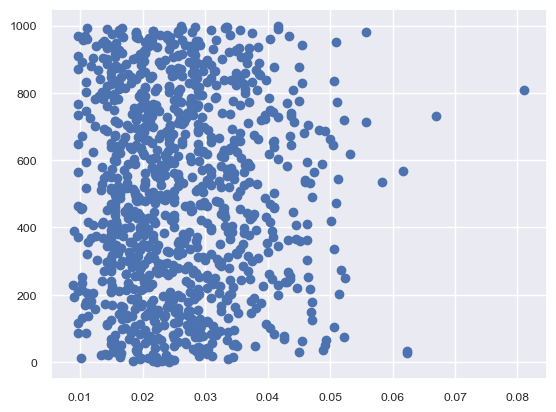

In [54]:
loss_plt = []
for i in all_loss:
    loss_plt.append(i.item())

plt.scatter(loss_plt,[x for x in range(len(loss_plt))])
plt.show()

In [55]:
model.eval()
test_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
        labels = labels.view(-1, 1)  # 타겟을 2D로 변환
        loss = criterion(predictions, labels)
        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {average_test_loss:.4f}')

Test Loss: 0.0248


In [58]:
correct = 0
total = 0

with torch.no_grad():  # 기울기를 계산하지 않도록 설정
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)  # MPS 장치로 이동
        batch_labels = batch_labels.to(device)      # MPS 장치로 이동

        outputs = model(batch_features)  # 모델 예측
        _, predicted = torch.max(outputs.data, 1)  # 가장 높은 확률의 클래스 선택

        total += batch_labels.size(0)  # 총 샘플 수
        correct += (predicted == batch_labels).sum().item()  # 맞춘 샘플 수

accuracy = 100 * correct / total  # 정확도 계산
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 0.00%
